# Vietnam IT Jobs - Data Merge and Analysis Pipeline

Merge two datasets:
1. Kaggle IT Jobs (ITViec)
2. GitHub IT-Job-Posting (Multiple sources)

Full pipeline: Schema Design → Column Mapping → Data Cleaning → Merge → Deduplicate → Feature Engineering → ML

## 1. Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print('Libraries imported successfully')

Libraries imported successfully


## 2. Load Raw Datasets

In [10]:
# Load Kaggle dataset
df_kaggle_jobs = pd.read_csv('data/raw/kaggle/jobs.csv')
df_kaggle_companies = pd.read_csv('data/raw/kaggle/companies.csv')
print(f'Kaggle jobs: {len(df_kaggle_jobs)}')
print(f'Kaggle companies: {len(df_kaggle_companies)}')
print(f'\nKaggle jobs columns: {list(df_kaggle_jobs.columns)}')
print(f'\nKaggle companies columns: {list(df_kaggle_companies.columns)}')

# Load GitHub dataset
df_github = pd.read_csv('data/raw/github/job_descriptions.csv')
print(f'\nGitHub jobs: {len(df_github)}')
print(f'GitHub columns: {list(df_github.columns)}')

Kaggle jobs: 1412
Kaggle companies: 2041

Kaggle jobs columns: ['job_id', 'company_id', 'job_name', 'taglist', 'location', 'three_reasons', 'description']

Kaggle companies columns: ['company_id', 'company_name', 'average_rating', 'num_review', 'city', 'type', 'num_employee', 'country', 'working_day', 'OT', 'overview', 'expertise', 'benifit', 'logo_link']

GitHub jobs: 3101
GitHub columns: ['title', 'company', 'company_image_url', 'location', 'description', 'site', 'job_url', 'it_role_type', 'main_programming_languages', 'key_technologies', 'city']


## 3. Schema Design - Define Master Table Structure

In [11]:
# Master schema columns
master_schema = {
    'job_id': 'Unique ID',
    'source_dataset': 'kaggle_itviec or github_it_job_posting',
    'job_site': 'itviec, linkedin, topcv, etc',
    'job_title': 'Job position title',
    'company_name': 'Company name',
    'location_raw': 'Original location string',
    'city': 'Normalized city',
    'province': 'Province/City',
    'country': 'Vietnam',
    'salary_raw': 'Original salary string',
    'salary_min': 'Min salary (normalized)',
    'salary_max': 'Max salary (normalized)',
    'salary_avg': 'Average salary',
    'salary_currency': 'VND or USD',
    'salary_period': 'month, year, etc',
    'job_level': 'intern, junior, mid, senior, lead, manager, etc',
    'employment_type': 'full_time, part_time, remote, etc',
    'job_category': 'backend, frontend, data, etc',
    'skills': 'List of skills separated by |',
    'job_description': 'Full description',
    'posted_date': 'Date posted (YYYY-MM-DD)',
    'url': 'Job URL'
}

print('Master Schema:')
for col, desc in master_schema.items():
    print(f'  {col:20s} : {desc}')

Master Schema:
  job_id               : Unique ID
  source_dataset       : kaggle_itviec or github_it_job_posting
  job_site             : itviec, linkedin, topcv, etc
  job_title            : Job position title
  company_name         : Company name
  location_raw         : Original location string
  city                 : Normalized city
  province             : Province/City
  country              : Vietnam
  salary_raw           : Original salary string
  salary_min           : Min salary (normalized)
  salary_max           : Max salary (normalized)
  salary_avg           : Average salary
  salary_currency      : VND or USD
  salary_period        : month, year, etc
  job_level            : intern, junior, mid, senior, lead, manager, etc
  employment_type      : full_time, part_time, remote, etc
  job_category         : backend, frontend, data, etc
  skills               : List of skills separated by |
  job_description      : Full description
  posted_date          : Date posted (YY

## 4. Column Mapping Functions

In [15]:
def map_kaggle_jobs(df_jobs, df_companies):
    """Map Kaggle jobs dataset to master schema"""
    # Merge jobs with companies to get company name
    df = df_jobs.merge(df_companies[['company_id', 'company_name', 'city']], 
                       on='company_id', how='left')
    
    mapped = pd.DataFrame()
    
    # Map columns explicitly
    if 'job_name' in df.columns:
        mapped['job_title'] = df['job_name']
    if 'company_name' in df.columns:
        mapped['company_name'] = df['company_name']
    if 'location' in df.columns:
        mapped['location_raw'] = df['location']
    if 'description' in df.columns:
        mapped['job_description'] = df['description']
    if 'taglist' in df.columns:
        mapped['skills'] = df['taglist']
    
    # Add source info
    mapped['source_dataset'] = 'kaggle_itviec'
    mapped['job_site'] = 'itviec'
    mapped['country'] = 'Vietnam'
    
    return mapped

def map_github_jobs(df):
    """Map GitHub dataset to master schema"""
    mapped = pd.DataFrame()
    
    # Map columns
    if 'title' in df.columns:
        mapped['job_title'] = df['title']
    if 'company' in df.columns:
        mapped['company_name'] = df['company']
    if 'location' in df.columns:
        mapped['location_raw'] = df['location']
    if 'description' in df.columns:
        mapped['job_description'] = df['description']
    if 'main_programming_languages' in df.columns:
        mapped['skills'] = df['main_programming_languages']
    if 'job_url' in df.columns:
        mapped['url'] = df['job_url']
    
    # Add source info
    mapped['source_dataset'] = 'github_it_job_posting'
    mapped['job_site'] = df.get('site', 'itviec')
    mapped['country'] = 'Vietnam'
    
    return mapped

print('Column mapping functions defined')

Column mapping functions defined


In [16]:
# Apply mapping
df_kaggle_clean = map_kaggle_jobs(df_kaggle_jobs, df_kaggle_companies)
df_github_clean = map_github_jobs(df_github)

print(f'Kaggle mapped: {len(df_kaggle_clean)} rows, {len(df_kaggle_clean.columns)} cols')
print(f'GitHub mapped: {len(df_github_clean)} rows, {len(df_github_clean.columns)} cols')
print(f'\nKaggle columns: {list(df_kaggle_clean.columns)}')
print(f'GitHub columns: {list(df_github_clean.columns)}')

Kaggle mapped: 1412 rows, 8 cols
GitHub mapped: 3101 rows, 9 cols

Kaggle columns: ['job_title', 'company_name', 'location_raw', 'job_description', 'skills', 'source_dataset', 'job_site', 'country']
GitHub columns: ['job_title', 'company_name', 'location_raw', 'job_description', 'skills', 'url', 'source_dataset', 'job_site', 'country']


## 5. Data Normalization Functions

In [14]:
def normalize_city(location):
    """Normalize city names"""
    if pd.isna(location):
        return 'Unknown'
    
    loc_lower = str(location).lower()
    
    city_map = {
        'ha noi': 'Ha Noi',
        'hà nội': 'Ha Noi',
        'hanoi': 'Ha Noi',
        'ho chi minh': 'Ho Chi Minh',
        'hồ chí minh': 'Ho Chi Minh',
        'hcm': 'Ho Chi Minh',
        'saigon': 'Ho Chi Minh',
        'da nang': 'Da Nang',
        'đà nẵng': 'Da Nang',
        'danang': 'Da Nang',
        'hai phong': 'Hai Phong',
        'can tho': 'Can Tho',
        'binh duong': 'Binh Duong',
        'dong nai': 'Dong Nai'
    }
    
    for key, value in city_map.items():
        if key in loc_lower:
            return value
    
    if 'remote' in loc_lower:
        return 'Remote'
    
    return 'Other'

def parse_salary(salary_str):
    """Parse salary string to min, max, currency"""
    if pd.isna(salary_str):
        return None, None, None, None
    
    s = str(salary_str).lower()
    
    # Determine currency
    currency = 'VND'
    if 'usd' in s or '$' in s:
        currency = 'USD'
    
    # Extract numbers
    numbers = re.findall(r'\d+', s.replace(',', '').replace('.', ''))
    if not numbers:
        return None, None, currency, 'month'
    
    nums = [int(n) for n in numbers]
    
    if len(nums) >= 2:
        salary_min = min(nums)
        salary_max = max(nums)
    else:
        salary_min = salary_max = nums[0]
    
    # Convert to VND if needed
    if currency == 'USD':
        salary_min = salary_min * 24000 if salary_min else None
        salary_max = salary_max * 24000 if salary_max else None
        currency = 'VND'
    
    # Handle millions
    if 'triệu' in s or 'tr' in s:
        salary_min = salary_min * 1000000 if salary_min else None
        salary_max = salary_max * 1000000 if salary_max else None
    
    salary_avg = (salary_min + salary_max) / 2 if salary_min and salary_max else None
    
    return salary_min, salary_max, salary_avg, currency

def extract_job_level(title):
    """Extract job level from title"""
    if pd.isna(title):
        return 'other'
    
    title_lower = str(title).lower()
    
    if any(w in title_lower for w in ['intern', 'fresher', 'graduate']):
        return 'intern'
    elif any(w in title_lower for w in ['junior', 'jr']):
        return 'junior'
    elif any(w in title_lower for w in ['senior', 'sr', 'lead', 'principal', 'staff']):
        return 'senior'
    elif any(w in title_lower for w in ['manager', 'head', 'director', 'chief', 'vp', 'cto', 'ceo']):
        return 'manager'
    else:
        return 'mid'

def categorize_job(title):
    """Categorize job role"""
    if pd.isna(title):
        return 'Other'
    
    title_lower = str(title).lower()
    
    categories = {
        'Backend Developer': ['backend', 'back-end', 'server'],
        'Frontend Developer': ['frontend', 'front-end', 'ui developer'],
        'Fullstack Developer': ['fullstack', 'full-stack', 'full stack'],
        'Mobile Developer': ['mobile', 'ios', 'android', 'flutter', 'react native'],
        'DevOps Engineer': ['devops', 'sre', 'infrastructure'],
        'Data Engineer': ['data engineer', 'etl', 'big data'],
        'Data Scientist': ['data scientist', 'data analyst', 'ml engineer', 'machine learning'],
        'QA/Tester': ['qa', 'qc', 'test', 'tester', 'quality assurance'],
        'Security Engineer': ['security', 'cybersecurity'],
        'Software Engineer': ['software engineer', 'software developer'],
        'Product Manager': ['product manager', 'product owner'],
        'Business Analyst': ['business analyst', 'ba']
    }
    
    for category, keywords in categories.items():
        if any(kw in title_lower for kw in keywords):
            return category
    
    return 'Other'

def normalize_skills(skills_str):
    """Normalize skills to pipe-separated format"""
    if pd.isna(skills_str):
        return ''
    
    s = str(skills_str)
    # Remove brackets and quotes
    s = s.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
    # Split and clean
    skills = [x.strip().lower() for x in s.split(',') if x.strip()]
    return '|'.join(skills) if skills else ''

print('Normalization functions defined')

Normalization functions defined


## 6. Apply Normalization

In [19]:
def apply_normalization(df):
    """Apply all normalization rules"""
    df = df.copy()
    
    # Normalize location
    if 'location_raw' in df.columns:
        df['city'] = df['location_raw'].apply(normalize_city)
        df['province'] = df['city']
    
    # Parse salary (initialize columns even if no salary_raw)
    if 'salary_raw' in df.columns:
        salary_parsed = df['salary_raw'].apply(parse_salary)
        df['salary_min'] = salary_parsed.apply(lambda x: x[0])
        df['salary_max'] = salary_parsed.apply(lambda x: x[1])
        df['salary_avg'] = salary_parsed.apply(lambda x: x[2])
        df['salary_currency'] = salary_parsed.apply(lambda x: x[3])
    else:
        # Initialize salary columns with None if no salary_raw
        df['salary_min'] = None
        df['salary_max'] = None
        df['salary_avg'] = None
        df['salary_currency'] = None
    
    # Extract job level and category
    if 'job_title' in df.columns:
        df['job_level'] = df['job_title'].apply(extract_job_level)
        df['job_category'] = df['job_title'].apply(categorize_job)
    
    # Normalize skills
    if 'skills' in df.columns:
        df['skills'] = df['skills'].apply(normalize_skills)
    
    # Employment type default
    if 'employment_type' not in df.columns:
        df['employment_type'] = 'full_time'
    
    return df

# Apply to both datasets
print('Normalizing Kaggle dataset...')
df_kaggle_normalized = apply_normalization(df_kaggle_clean)
print(f'Done: {len(df_kaggle_normalized)} jobs')

print('\nNormalizing GitHub dataset...')
df_github_normalized = apply_normalization(df_github_clean)
print(f'Done: {len(df_github_normalized)} jobs')

print(f'\nKaggle normalized columns: {list(df_kaggle_normalized.columns)}')
print(f'GitHub normalized columns: {list(df_github_normalized.columns)}')

Normalizing Kaggle dataset...
Done: 1412 jobs

Normalizing GitHub dataset...
Done: 3101 jobs

Kaggle normalized columns: ['job_title', 'company_name', 'location_raw', 'job_description', 'skills', 'source_dataset', 'job_site', 'country', 'city', 'province', 'salary_min', 'salary_max', 'salary_avg', 'salary_currency', 'job_level', 'job_category', 'employment_type']
GitHub normalized columns: ['job_title', 'company_name', 'location_raw', 'job_description', 'skills', 'url', 'source_dataset', 'job_site', 'country', 'city', 'province', 'salary_min', 'salary_max', 'salary_avg', 'salary_currency', 'job_level', 'job_category', 'employment_type']


## 7. Merge and Deduplicate

In [20]:
# Align columns
all_columns = set(df_kaggle_normalized.columns) | set(df_github_normalized.columns)
for col in all_columns:
    if col not in df_kaggle_normalized.columns:
        df_kaggle_normalized[col] = None
    if col not in df_github_normalized.columns:
        df_github_normalized[col] = None

# Merge
df_merged = pd.concat([df_kaggle_normalized, df_github_normalized], ignore_index=True)
print(f'Total after merge: {len(df_merged)} jobs')

# Remove rows with missing critical fields
df_merged = df_merged.dropna(subset=['job_title', 'company_name'])
df_merged = df_merged[df_merged['job_title'].str.strip() != '']
df_merged = df_merged[df_merged['company_name'].str.strip() != '']
print(f'After removing empty critical fields: {len(df_merged)} jobs')

# Deduplicate based on title + company + city
df_merged['_dedup_key'] = (
    df_merged['job_title'].str.lower().str.strip() + '_' +
    df_merged['company_name'].str.lower().str.strip() + '_' +
    df_merged['city'].fillna('').str.lower()
)

print(f'\nBefore deduplication: {len(df_merged)} jobs')
df_merged = df_merged.sort_values('source_dataset').drop_duplicates(subset='_dedup_key', keep='first')
df_merged = df_merged.drop('_dedup_key', axis=1)
print(f'After deduplication: {len(df_merged)} jobs')

# Generate job_id
df_merged['job_id'] = ['job_' + str(i).zfill(6) for i in range(len(df_merged))]

# Reorder columns
priority_cols = ['job_id', 'source_dataset', 'job_site', 'job_title', 'company_name', 
                 'city', 'job_category', 'job_level', 'salary_min', 'salary_max']
other_cols = [c for c in df_merged.columns if c not in priority_cols]
df_master = df_merged[priority_cols + other_cols]

print(f'\nMaster table created: {len(df_master)} jobs')
print(f'Columns: {len(df_master.columns)}')

Total after merge: 4513 jobs
After removing empty critical fields: 4513 jobs

Before deduplication: 4513 jobs
After deduplication: 3985 jobs

Master table created: 3985 jobs
Columns: 19


## 8. Data Quality Check

In [21]:
print('DATA QUALITY REPORT')
print('=' * 70)

print(f'\nTotal jobs in master table: {len(df_master):,}')

print(f'\nBy source:')
print(df_master['source_dataset'].value_counts())

print(f'\nBy job site:')
print(df_master['job_site'].value_counts())

print(f'\nBy city:')
print(df_master['city'].value_counts().head(10))

print(f'\nBy job category:')
print(df_master['job_category'].value_counts().head(10))

print(f'\nBy job level:')
print(df_master['job_level'].value_counts())

print(f'\nMissing values:')
missing = df_master.isnull().sum()
missing_pct = (missing / len(df_master) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False))

print(f'\nSalary statistics:')
salary_available = df_master['salary_avg'].notna().sum()
print(f'Jobs with salary: {salary_available:,} ({salary_available/len(df_master)*100:.1f}%)')
if salary_available > 0:
    print(f'Average salary: {df_master["salary_avg"].mean()/1000000:.1f} million VND/month')
    print(f'Median salary: {df_master["salary_avg"].median()/1000000:.1f} million VND/month')

DATA QUALITY REPORT

Total jobs in master table: 3,985

By source:
source_dataset
github_it_job_posting    2574
kaggle_itviec            1411
Name: count, dtype: int64

By job site:
job_site
itviec      1411
LinkedIn     995
ITViec       923
TopCV        656
Name: count, dtype: int64

By city:
city
Ho Chi Minh    2060
Ha Noi         1431
Other           364
Da Nang         115
Remote            6
Hai Phong         3
Can Tho           3
Binh Duong        2
Dong Nai          1
Name: count, dtype: int64

By job category:
job_category
Other                  1615
Backend Developer       374
Fullstack Developer     345
QA/Tester               338
Mobile Developer        303
Frontend Developer      292
Software Engineer       249
Business Analyst        185
DevOps Engineer          87
Data Engineer            71
Name: count, dtype: int64

By job level:
job_level
mid        2618
senior      928
junior      198
manager     131
intern      110
Name: count, dtype: int64

Missing values:
         

## 9. Save Processed Data

In [22]:
# Save master table
df_master.to_csv('data/final/jobs_master.csv', index=False)
df_master.to_parquet('data/final/jobs_master.parquet', index=False)
print(f'Saved master table: {len(df_master)} jobs')

# Save intermediate tables
df_kaggle_normalized.to_csv('data/processed/jobs_kaggle_clean.csv', index=False)
df_github_normalized.to_csv('data/processed/jobs_github_clean.csv', index=False)
print('Saved intermediate tables')

print('\nAll data saved to:')
print('  data/final/jobs_master.csv')
print('  data/final/jobs_master.parquet')
print('  data/processed/jobs_kaggle_clean.csv')
print('  data/processed/jobs_github_clean.csv')

Saved master table: 3985 jobs
Saved intermediate tables

All data saved to:
  data/final/jobs_master.csv
  data/final/jobs_master.parquet
  data/processed/jobs_kaggle_clean.csv
  data/processed/jobs_github_clean.csv


## 10. Exploratory Data Analysis

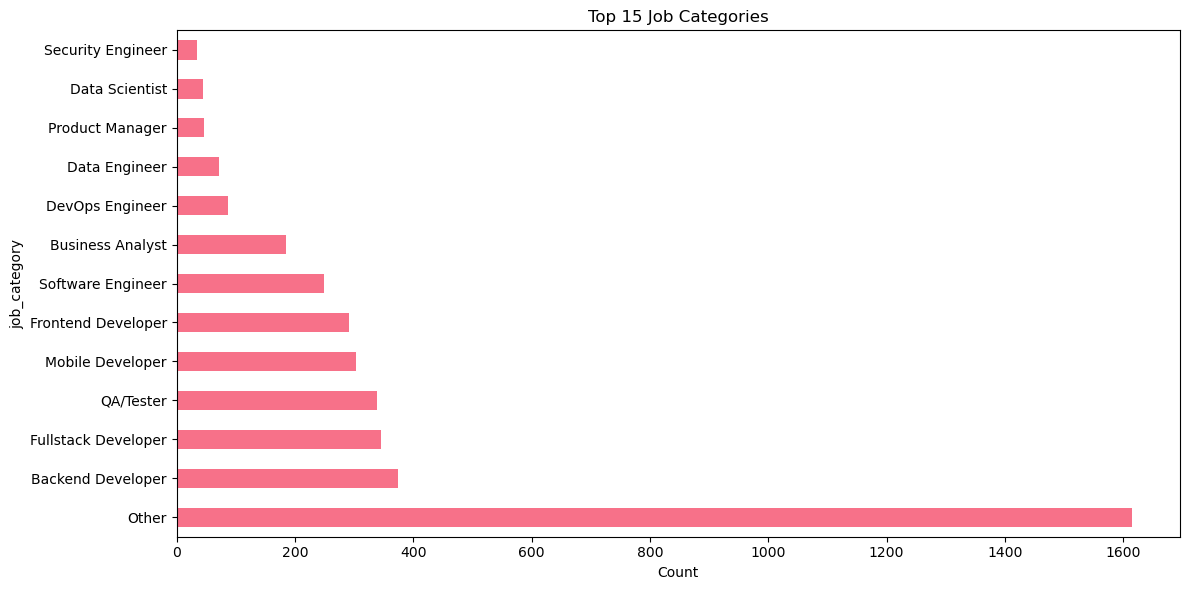

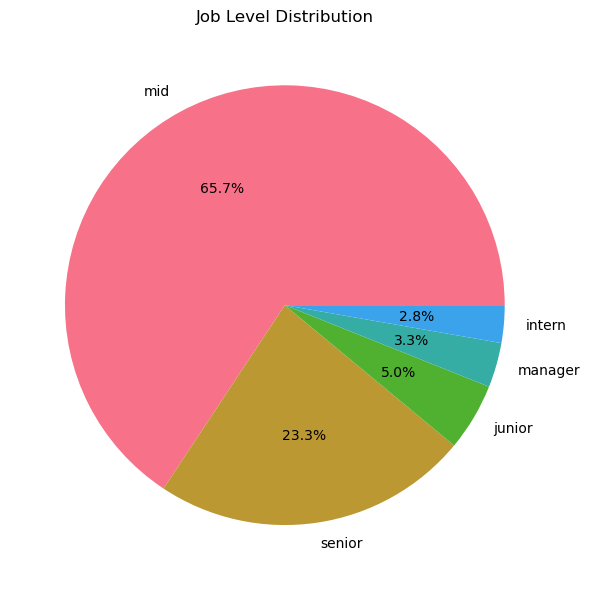

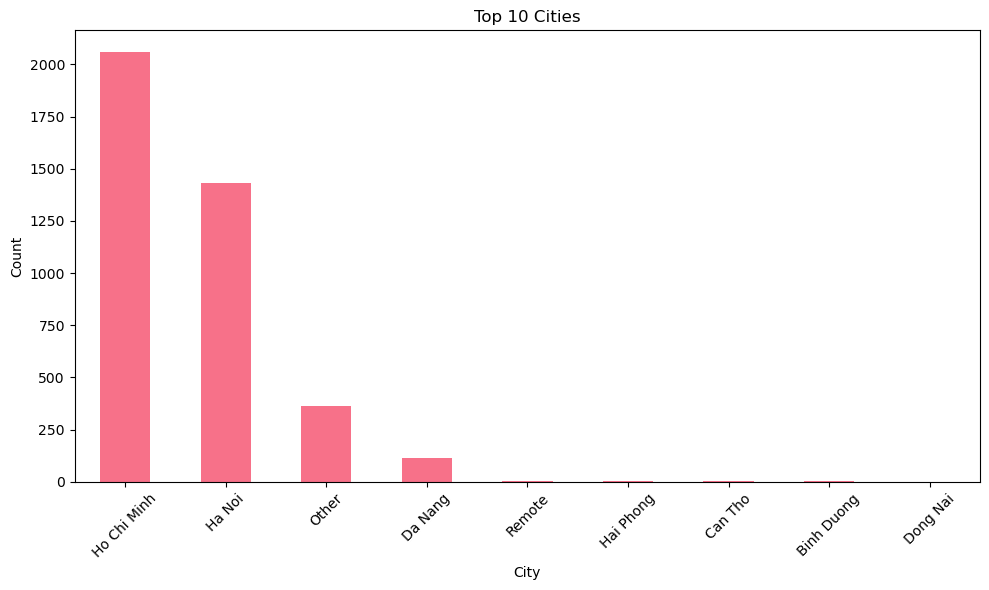

In [23]:
# Job category distribution
plt.figure(figsize=(12, 6))
df_master['job_category'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Job Categories')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Job level distribution
plt.figure(figsize=(10, 6))
df_master['job_level'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Job Level Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

# City distribution
plt.figure(figsize=(10, 6))
df_master['city'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Cities')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Salary distribution
if df_master['salary_avg'].notna().sum() > 100:
    plt.figure(figsize=(12, 6))
    salary_data = df_master['salary_avg'].dropna() / 1000000
    salary_data[salary_data <= 100].hist(bins=30, edgecolor='black')
    plt.title('Salary Distribution')
    plt.xlabel('Salary (Million VND/month)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 11. Feature Engineering for ML

In [24]:
# Filter for ML (roles with enough samples)
category_counts = df_master['job_category'].value_counts()
valid_categories = category_counts[category_counts >= 50].index.tolist()
df_ml = df_master[df_master['job_category'].isin(valid_categories)].copy()

print(f'Jobs for ML: {len(df_ml)} ({len(df_ml)/len(df_master)*100:.1f}%)')
print(f'Categories: {len(valid_categories)}')
print(f'Category list: {valid_categories}')

# Create text features
df_ml['text'] = (
    df_ml['job_title'].fillna('') + ' ' + 
    df_ml['job_description'].fillna('') + ' ' + 
    df_ml['skills'].fillna('')
)

# TF-IDF
print('\nCreating TF-IDF features...')
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), stop_words='english')
X_tfidf = tfidf.fit_transform(df_ml['text'])
print(f'TF-IDF shape: {X_tfidf.shape}')

# Additional features
le_level = LabelEncoder()
le_city = LabelEncoder()

df_ml['level_encoded'] = le_level.fit_transform(df_ml['job_level'])
df_ml['city_encoded'] = le_city.fit_transform(df_ml['city'])
df_ml['has_salary'] = df_ml['salary_avg'].notna().astype(int)
df_ml['title_length'] = df_ml['job_title'].str.len()
df_ml['desc_length'] = df_ml['job_description'].fillna('').str.len()

feature_cols = ['level_encoded', 'city_encoded', 'has_salary', 'title_length', 'desc_length']
X_additional = df_ml[feature_cols].values

# Combine features
from scipy.sparse import hstack
X = hstack([X_tfidf, X_additional])
print(f'Total features: {X.shape[1]}')

# Target
le_target = LabelEncoder()
y = le_target.fit_transform(df_ml['job_category'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTrain: {X_train.shape[0]} samples')
print(f'Test: {X_test.shape[0]} samples')

Jobs for ML: 3859 (96.8%)
Categories: 10
Category list: ['Other', 'Backend Developer', 'Fullstack Developer', 'QA/Tester', 'Mobile Developer', 'Frontend Developer', 'Software Engineer', 'Business Analyst', 'DevOps Engineer', 'Data Engineer']

Creating TF-IDF features...
TF-IDF shape: (3859, 500)
Total features: 505

Train: 3087 samples
Test: 772 samples


## 12. Model Training

In [25]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'accuracy': acc, 'predictions': y_pred}
    print(f'{name} Accuracy: {acc:.4f}')

best_name = max(results, key=lambda x: results[x]['accuracy'])
print(f'\nBest model: {best_name} ({results[best_name]["accuracy"]:.4f})')


Training Random Forest...
Random Forest Accuracy: 0.6917

Training XGBoost...
XGBoost Accuracy: 0.7746

Best model: XGBoost (0.7746)


## 13. Model Evaluation


Classification Report:
                     precision    recall  f1-score   support

  Backend Developer       0.69      0.65      0.67        75
   Business Analyst       0.81      0.59      0.69        37
      Data Engineer       0.79      0.79      0.79        14
    DevOps Engineer       0.62      0.76      0.68        17
 Frontend Developer       0.85      0.76      0.80        58
Fullstack Developer       0.77      0.48      0.59        69
   Mobile Developer       0.85      0.85      0.85        61
              Other       0.75      0.87      0.80       323
          QA/Tester       0.96      0.94      0.95        68
  Software Engineer       0.70      0.60      0.65        50

           accuracy                           0.77       772
          macro avg       0.78      0.73      0.75       772
       weighted avg       0.78      0.77      0.77       772



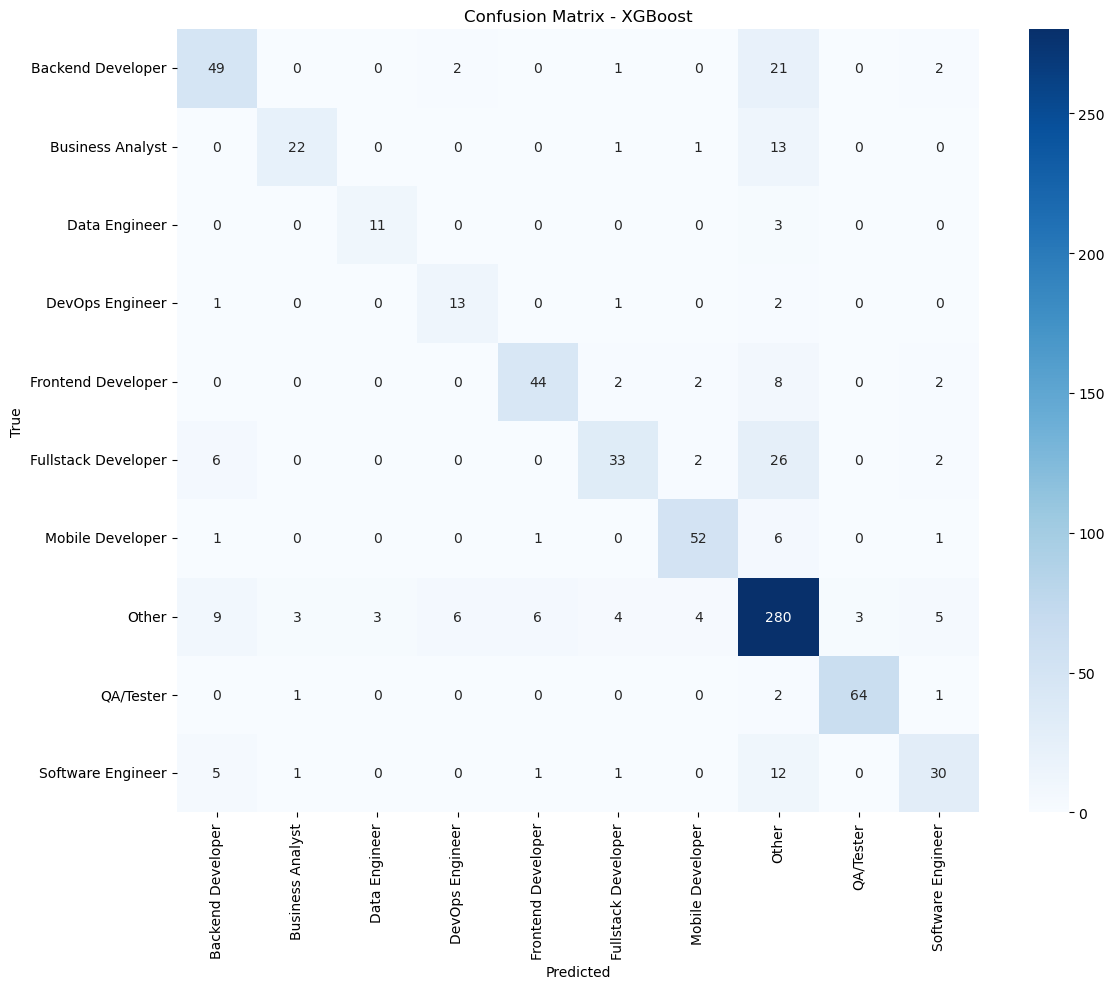

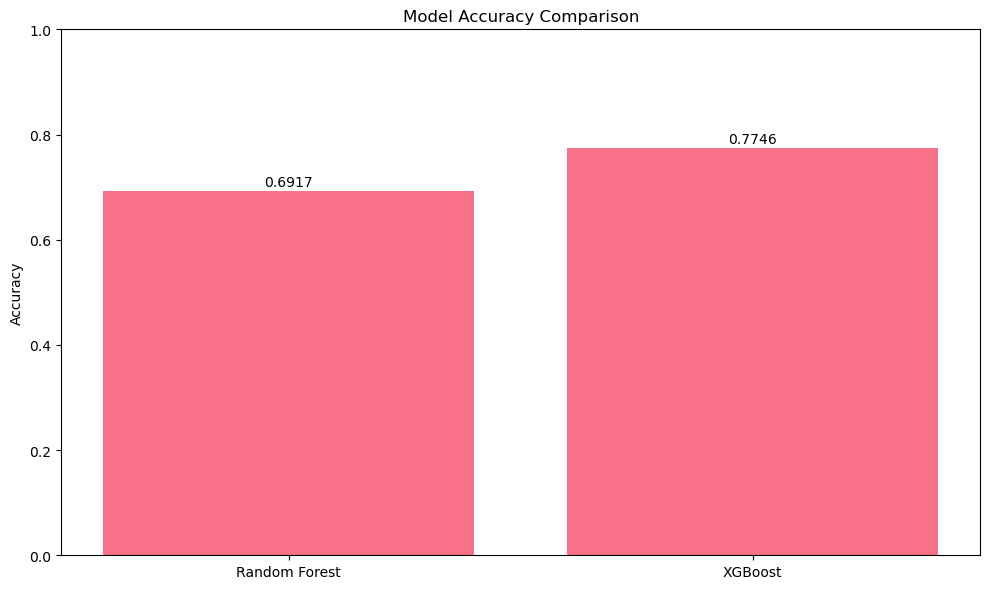

In [26]:
# Classification report
y_pred_best = results[best_name]['predictions']
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Model comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

## 14. Save Models

In [27]:
# Save best model
model_data = {
    'model': results[best_name]['model'],
    'tfidf': tfidf,
    'le_target': le_target,
    'le_level': le_level,
    'le_city': le_city,
    'feature_cols': feature_cols,
    'accuracy': results[best_name]['accuracy'],
    'model_name': best_name
}

with open('data/final/best_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f'Saved best model: {best_name}')
print(f'Accuracy: {results[best_name]["accuracy"]:.4f}')
print('\nModel saved to: data/final/best_model.pkl')

Saved best model: XGBoost
Accuracy: 0.7746

Model saved to: data/final/best_model.pkl


## 15. Final Summary

In [28]:
print('=' * 80)
print('VIETNAM IT JOBS - DATA MERGE AND ANALYSIS SUMMARY')
print('=' * 80)

print(f'\nDATA MERGE:')
print(f'  Kaggle (ITViec): {len(df_kaggle_normalized)} jobs')
print(f'  GitHub (Multi-source): {len(df_github_normalized)} jobs')
print(f'  Master table: {len(df_master)} unique jobs')
print(f'  Deduplication rate: {(1 - len(df_master)/(len(df_kaggle_normalized)+len(df_github_normalized)))*100:.1f}%')

print(f'\nDATA DISTRIBUTION:')
print(f'  Sources: {df_master["source_dataset"].nunique()}')
print(f'  Job sites: {df_master["job_site"].nunique()}')
print(f'  Cities: {df_master["city"].nunique()}')
print(f'  Companies: {df_master["company_name"].nunique()}')
print(f'  Job categories: {df_master["job_category"].nunique()}')

print(f'\nMACHINE LEARNING:')
print(f'  ML dataset: {len(df_ml)} jobs')
print(f'  Categories: {len(valid_categories)}')
print(f'  Features: {X.shape[1]}')
print(f'  Best model: {best_name}')
print(f'  Accuracy: {results[best_name]["accuracy"]:.4f}')

print(f'\nTOP 5 JOB CATEGORIES:')
for cat, count in df_master['job_category'].value_counts().head(5).items():
    print(f'  {cat}: {count:,} jobs ({count/len(df_master)*100:.1f}%)')

print(f'\nFILES SAVED:')
print(f'  data/final/jobs_master.csv')
print(f'  data/final/jobs_master.parquet')
print(f'  data/final/best_model.pkl')
print(f'  data/processed/jobs_kaggle_clean.csv')
print(f'  data/processed/jobs_github_clean.csv')

print('\n' + '=' * 80)
print('PIPELINE COMPLETE')
print('=' * 80)

VIETNAM IT JOBS - DATA MERGE AND ANALYSIS SUMMARY

DATA MERGE:
  Kaggle (ITViec): 1412 jobs
  GitHub (Multi-source): 3101 jobs
  Master table: 3985 unique jobs
  Deduplication rate: 11.7%

DATA DISTRIBUTION:
  Sources: 2
  Job sites: 4
  Cities: 9
  Companies: 1901
  Job categories: 13

MACHINE LEARNING:
  ML dataset: 3859 jobs
  Categories: 10
  Features: 505
  Best model: XGBoost
  Accuracy: 0.7746

TOP 5 JOB CATEGORIES:
  Other: 1,615 jobs (40.5%)
  Backend Developer: 374 jobs (9.4%)
  Fullstack Developer: 345 jobs (8.7%)
  QA/Tester: 338 jobs (8.5%)
  Mobile Developer: 303 jobs (7.6%)

FILES SAVED:
  data/final/jobs_master.csv
  data/final/jobs_master.parquet
  data/final/best_model.pkl
  data/processed/jobs_kaggle_clean.csv
  data/processed/jobs_github_clean.csv

PIPELINE COMPLETE
